# Data download and complete the data set by interpolation

In [30]:
import yfinance as yf
import pandas as pd
import numpy as np

# Step 1: Load tickers from the specified CSV
tickers_df = pd.read_csv('/Users/xiannvying/Desktop/3A/FINA/Weefin_gestion_portefeuille/projet/portfolio.csv')
tickers = tickers_df['Symbol'].dropna().tolist()

# Step 2: Download price of stocks
data = yf.download(tickers, start='2015-01-01', end='2023-01-01')['Adj Close']

# Step 3: Time index for stocks
data.index = data.index.strftime('%Y-%m-%d')

# Step 4: Remove stocks with more than 10% missing data
threshold = 0.1  # 10% missing data threshold
max_missing_allowed = int(threshold * len(data))
data_filtered = data.loc[:, data.isnull().sum() <= max_missing_allowed]
data_final = data_filtered.dropna()

# Step 5: Interpolate the remaining data
data_interpolated = data_filtered.interpolate(method='linear', axis=0)

# Step 6: Verify if there is any remaining missing data
remaining_missing = data_interpolated.isnull().sum().sum()
if remaining_missing == 0:
    print("All data complete after filtering and interpolation!")
else:
    print(f"{remaining_missing} missing values remain after processing.")




# Final Step: Print the processed data
print(data_interpolated)
data_stock = data_interpolated

[*********************100%***********************]  206 of 206 completed


All data complete after filtering and interpolation!
Ticker               A        AAPL        ABBV         ACN        ADBE  \
Date                                                                     
2015-01-02   37.422070   24.347172   43.563187   75.312729   72.339996   
2015-01-05   36.720844   23.661276   42.743351   74.041145   71.980003   
2015-01-06   36.148815   23.663506   42.531788   73.507050   70.529999   
2015-01-07   36.628582   23.995321   44.250774   75.049934   71.110001   
2015-01-08   37.726517   24.917269   44.713589   76.194389   72.919998   
...                ...         ...         ...         ...         ...   
2022-12-23  147.185074  130.487808  151.238403  257.784515  338.450012   
2022-12-27  147.500687  128.676849  151.136383  257.028900  335.089996   
2022-12-28  146.060684  124.728371  150.431641  254.907242  328.329987   
2022-12-29  149.019608  128.261200  150.737656  260.003021  337.579987   
2022-12-30  147.819443  128.577866  149.856750  258.511139 

# Bond data

Average Yield (10 Year): 2.46326152525475%


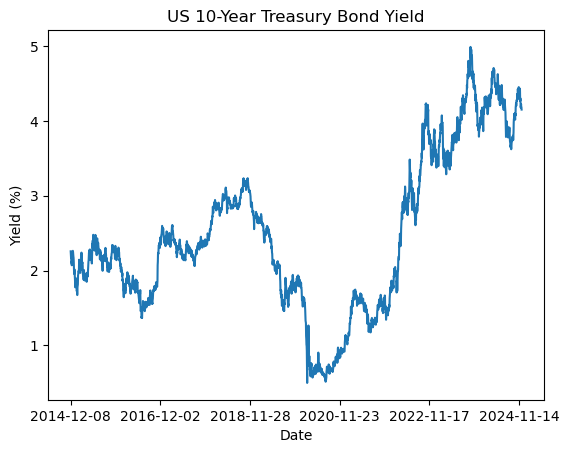

In [31]:
import yfinance as yf

# Example: Fetching US 10-Year Treasury bond yield (^TNX)
bond = yf.Ticker("^TNX")
data_bond = bond.history(period="10y")
data_bond.index = data_bond.index.strftime('%Y-%m-%d')

# Calculate average yield
average_yield = data_bond['Close'].mean()
print(f"Average Yield (10 Year): {average_yield}%")

# Plot yield trend
import matplotlib.pyplot as plt
data_bond['Close'].plot(title="US 10-Year Treasury Bond Yield")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.show()

data_bond = data_bond['Close']

## Benchmark

In [32]:
index = ['^GSPC']  # S&P 500 index
data_sp500 = yf.download(index, start='2015-01-01', end='2023-01-01')['Adj Close']
data_sp500.index = data_sp500.index.strftime('%Y-%m-%d')

[*********************100%***********************]  1 of 1 completed


## traitement

In [33]:
# Align the date range
common_start_date = max(data_stock.index.min(), data_bond.index.min())
common_end_date = min(data_stock.index.max(), data_bond.index.max())
data_stock = data_stock.loc[common_start_date:common_end_date]
data_bond = data_bond.loc[common_start_date:common_end_date]

# Handle missing values
data_stock = data_stock.interpolate(method='linear')
data_bond = data_bond.interpolate(method='linear')

# Ensure alignment along the index
data_stock, data_bond = data_stock.align(data_bond, join='inner', axis=0)

# Verify alignment
assert data_stock.shape[0] == data_bond.shape[0], "Datasets are not aligned!"
assert all(data_stock.index == data_bond.index), "Indices do not match!"

print(f"Aligned Data Shape: {data_stock.shape}")


Aligned Data Shape: (2013, 168)


In [34]:
# Align the date range for all datasets
common_start_date = max(data_stock.index.min(), data_bond.index.min(), data_sp500.index.min())
common_end_date = min(data_stock.index.max(), data_bond.index.max(), data_sp500.index.max())
data_stock = data_stock.loc[common_start_date:common_end_date]
data_bond = data_bond.loc[common_start_date:common_end_date]
data_sp500 = data_sp500.loc[common_start_date:common_end_date]

# Handle missing values
data_stock = data_stock.interpolate(method='linear')
data_bond = data_bond.interpolate(method='linear')
data_sp500 = data_sp500.interpolate(method='linear')

# Ensure alignment along the index for all three datasets
data_stock, data_bond = data_stock.align(data_bond, join='inner', axis=0)
data_stock, data_sp500 = data_stock.align(data_sp500, join='inner', axis=0)

# Verify alignment
assert data_stock.shape[0] == data_bond.shape[0] == data_sp500.shape[0], "Datasets are not aligned!"
assert all(data_stock.index == data_bond.index) and all(data_stock.index == data_sp500.index), "Indices do not match!"

print(f"Aligned Data Shape: {data_stock.shape}")


Aligned Data Shape: (2013, 168)


Ratio of pure stock portfoli

Sortino Ratio: 0.07485054476225603
Treynor Ratio: 0.0006658235830013807
Information Ratio: 0.09594314166700334
Portfolio Beta: 1.0359098221184686


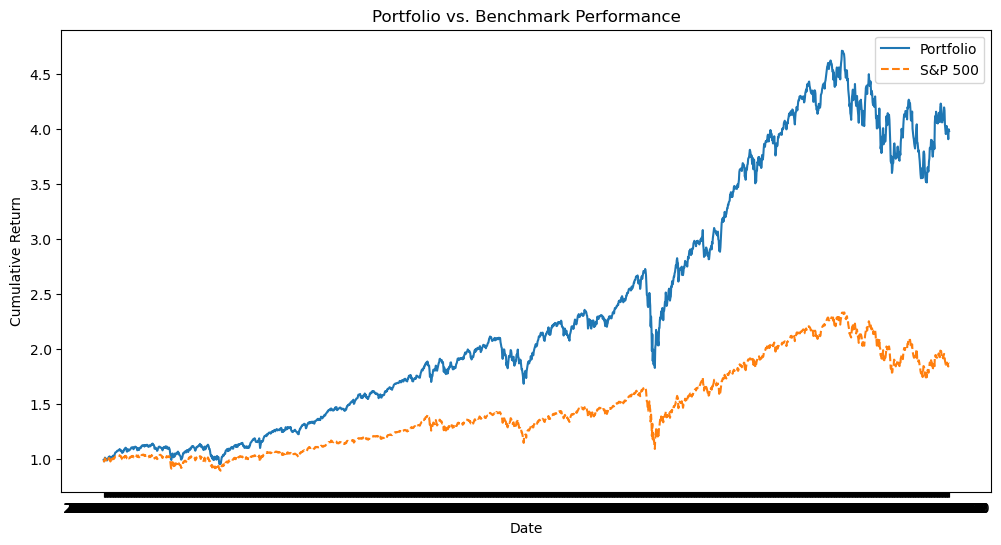

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes data_stock, data_sp500, and data_bond are already loaded
# Step 1: Calculate daily returns
stock_returns = data_stock.pct_change().dropna()  # Portfolio stock returns
benchmark_returns = data_sp500.pct_change().dropna()  # S&P 500 returns

# Step 2: Calculate average daily risk-free rate from bond yield
average_yield = data_bond.mean() / 100  # Convert to decimal
daily_risk_free_rate = (1 + average_yield) ** (1 / 252) - 1

# Step 3: Calculate portfolio returns (equally weighted portfolio as an example)
weights = np.ones(stock_returns.shape[1]) / stock_returns.shape[1]  # Equal weights
portfolio_returns = stock_returns.dot(weights)

# Step 4: Define metric calculation functions
def calculate_sortino_ratio(returns, risk_free_rate, target_return=0):
    excess_returns = returns - risk_free_rate
    downside_returns = np.minimum(excess_returns - target_return, 0)
    downside_deviation = np.sqrt(np.mean(downside_returns**2))
    sortino_ratio = np.mean(excess_returns) / downside_deviation if downside_deviation != 0 else np.nan
    return sortino_ratio

def calculate_treynor_ratio(returns, risk_free_rate, beta):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / beta

def calculate_information_ratio(returns, benchmark_returns):
    # Align the two return series
    aligned_returns = pd.concat([returns, benchmark_returns], axis=1, join="inner")
    aligned_returns.columns = ['Portfolio', 'Benchmark']
    
    # Calculate active returns
    active_return = aligned_returns['Portfolio'] - aligned_returns['Benchmark']
    
    # Calculate tracking error and information ratio
    tracking_error = np.std(active_return)
    return np.mean(active_return) / tracking_error if tracking_error != 0 else np.nan


def calculate_beta(portfolio_returns, benchmark_returns):
    covariance = np.cov(portfolio_returns, benchmark_returns)[0, 1]
    benchmark_variance = np.var(benchmark_returns)
    return covariance / benchmark_variance

# Align portfolio and benchmark returns
aligned_returns = pd.concat([portfolio_returns, benchmark_returns], axis=1, join="inner")
aligned_returns.columns = ['Portfolio', 'Benchmark']

# Beta calculation function
def calculate_beta(portfolio_returns, benchmark_returns):
    covariance = np.cov(portfolio_returns, benchmark_returns)[0, 1]
    benchmark_variance = np.var(benchmark_returns)
    return covariance / benchmark_variance

# Use aligned data for beta calculation
portfolio_beta = calculate_beta(
    aligned_returns['Portfolio'].values,
    aligned_returns['Benchmark'].values
)


# Step 5: Calculate metrics

sortino_ratio = calculate_sortino_ratio(portfolio_returns, daily_risk_free_rate)
treynor_ratio = calculate_treynor_ratio(portfolio_returns, daily_risk_free_rate, portfolio_beta)
information_ratio = calculate_information_ratio(portfolio_returns, benchmark_returns)

# Step 6: Display results
print(f"Sortino Ratio: {sortino_ratio}")
print(f"Treynor Ratio: {treynor_ratio}")
print(f"Information Ratio: {information_ratio}")
print(f"Portfolio Beta: {portfolio_beta}")

# Step 7: Optional: Plot portfolio vs. benchmark cumulative returns
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio, label="Portfolio")
plt.plot(cumulative_benchmark, label="S&P 500", linestyle="--")
plt.title("Portfolio vs. Benchmark Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


# CPPI

## rolling floor

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define training and testing periods
train_start, train_end = "2015-01-01", "2018-12-31"
test_start, test_end = "2019-01-01", "2023-12-31"

# Parameters
initial_portfolio_value = 100000
floor_percentage = 0.8
multiplier = 3

# Function to calculate risk-free rate
def calculate_risk_free_rate(data_bond):
    return data_bond.pct_change().mean().mean()

# Function to apply CPPI with or without rolling floor
def apply_cppi(stock_returns, risk_free_rate, floor_percentage, initial_value, multiplier, rolling_floor=False):
    portfolio_value = initial_value
    max_portfolio_value = initial_value
    portfolio_values = []
    floor_values = []

    for daily_return in stock_returns.mean(axis=1):  # Equal-weighted stock returns
        # Update the floor (rolling or static)
        floor = floor_percentage * (max_portfolio_value if rolling_floor else initial_value)

        # Calculate cushion and allocations
        cushion = max(portfolio_value - floor, 0)
        risky_allocation = min(multiplier * cushion, portfolio_value)
        risk_free_allocation = portfolio_value - risky_allocation

        # Compute portfolio return and update values
        portfolio_return = risky_allocation * daily_return + risk_free_allocation * risk_free_rate
        portfolio_value += portfolio_return
        max_portfolio_value = max(max_portfolio_value, portfolio_value)

        # Store values
        portfolio_values.append(portfolio_value)
        floor_values.append(floor)
    
    return portfolio_values, floor_values

# Function to calculate performance metrics
def calculate_metrics(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(returns)
    volatility = np.std(returns) * np.sqrt(252)
    car = np.cumprod(1 + returns)[-1] ** (252 / len(returns)) - 1
    cumulative = np.cumprod(1 + returns)
    drawdown = cumulative / np.maximum.accumulate(cumulative) - 1
    max_drawdown = drawdown.min()
    return sharpe_ratio, volatility, car, max_drawdown

# Function to perform simulations and generate a summary table
def simulate_cppi(stock_returns, risk_free_rate, initial_value, floor_percentage, multiplier, rolling_floor):
    simulations = 1000
    sharpe_ratios, volatilities, cumulative_returns, max_drawdowns, dd_95_percentiles = [], [], [], [], []

    for _ in range(simulations):
        simulated_returns = np.random.choice(stock_returns.mean(axis=1), size=len(stock_returns), replace=True)
        simulated_values, _ = apply_cppi(
            stock_returns=pd.DataFrame(simulated_returns),
            risk_free_rate=risk_free_rate,
            floor_percentage=floor_percentage,
            initial_value=initial_value,
            multiplier=multiplier,
            rolling_floor=rolling_floor
        )
        simulated_returns = np.diff(simulated_values) / simulated_values[:-1]
        sharpe, vol, car, max_dd = calculate_metrics(simulated_returns, risk_free_rate)
        sharpe_ratios.append(sharpe)
        volatilities.append(vol)
        cumulative_returns.append(car)
        max_drawdowns.append(max_dd)
        drawdown = np.cumprod(1 + simulated_returns) / np.maximum.accumulate(np.cumprod(1 + simulated_returns)) - 1
        dd_95_percentiles.append(np.percentile(drawdown, 5))

    simulation_results = pd.DataFrame({
        "Sharpe Ratio": sharpe_ratios,
        "Volatility p.a.": volatilities,
        "CAR p.a.": cumulative_returns,
        "Max Drawdown": max_drawdowns,
        "95% DD": dd_95_percentiles
    })

    summary_table = pd.DataFrame({
        "Metric": ["Sharpe Ratio", "Volatility p.a.", "CAR p.a.", "Max Drawdown", "95% DD"],
        "5th Percentile": simulation_results.quantile(0.05),
        "Median": simulation_results.median(),
        "95th Percentile": simulation_results.quantile(0.95)
    }).set_index("Metric")

    summary_table.loc["CAR / Max DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["Max Drawdown"])
    summary_table.loc["CAR / 95% DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["95% DD"])

    return summary_table

# Load and process data
train_stock = data_stock.loc[train_start:train_end]
test_stock = data_stock.loc[test_start:test_end]
train_bond = data_bond.loc[train_start:train_end]
test_bond = data_bond.loc[test_start:test_end]

risk_free_rate_train = calculate_risk_free_rate(train_bond)
risk_free_rate_test = calculate_risk_free_rate(test_bond)

train_stock_returns = train_stock.pct_change().dropna()
test_stock_returns = test_stock.pct_change().dropna()

# Apply CPPI with rolling floor and simulate results
summary_table = simulate_cppi(
    stock_returns=test_stock_returns,
    risk_free_rate=risk_free_rate_test,
    initial_value=initial_portfolio_value,
    floor_percentage=floor_percentage,
    multiplier=multiplier,
    rolling_floor=True
)

# Print and visualize results
print(summary_table)


                 5th Percentile    Median  95th Percentile
Metric                                                    
Sharpe Ratio          -0.078280 -0.024038         0.025495
Volatility p.a.        0.122491  0.132405         0.143152
CAR p.a.               0.170576  0.309556         0.454061
Max Drawdown          -0.131310 -0.100141        -0.074331
95% DD                -0.102639 -0.071388        -0.050675
CAR / Max DD           1.299032  3.091191         6.108673
CAR / 95% DD           1.661910  4.336220         8.960257


## dynamic_multiplier

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
train_start, train_end = "2015-01-01", "2018-12-31"
test_start, test_end = "2019-01-01", "2023-12-31"
initial_portfolio_value = 100000
floor_percentage = 0.8  # Rolling floor percentage
target_volatility = 0.11  # Target volatility for dynamic multiplier

# Function to calculate the risk-free rate
def calculate_risk_free_rate(data_bond):
    return data_bond.pct_change().mean().mean()

# Function to calculate a dynamic multiplier
def dynamic_multiplier(volatility, target_volatility=0.15):
    """
    Adjust multiplier dynamically based on target volatility.
    """
    return min(5, max(1, target_volatility / volatility))

# Apply CPPI with dynamic multiplier
def apply_cppi_dynamic(stock_returns, risk_free_rate, floor_percentage, initial_value, target_volatility=None):
    """
    CPPI implementation with a dynamic multiplier based on target volatility.
    """
    portfolio_value = initial_value
    max_portfolio_value = initial_value
    portfolio_values = []
    floor_values = []

    for daily_return in stock_returns.mean(axis=1):
        # Update floor
        floor = floor_percentage * max_portfolio_value

        # Calculate realized volatility (rolling window) for dynamic multiplier
        if target_volatility is not None:
            realized_vol = stock_returns.rolling(window=20).std().mean(axis=1).iloc[-1]
            multiplier = dynamic_multiplier(realized_vol, target_volatility)
        else:
            multiplier = 4  # Default fixed multiplier (fallback)

        # Calculate cushion and allocations
        cushion = max(portfolio_value - floor, 0)
        risky_allocation = min(multiplier * cushion, portfolio_value)
        risk_free_allocation = portfolio_value - risky_allocation

        # Compute portfolio return
        portfolio_return = risky_allocation * daily_return + risk_free_allocation * risk_free_rate
        portfolio_value += portfolio_return
        max_portfolio_value = max(max_portfolio_value, portfolio_value)

        # Store values
        portfolio_values.append(portfolio_value)
        floor_values.append(floor)

    return portfolio_values, floor_values

# Function to calculate portfolio performance metrics
def calculate_metrics(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(returns)
    volatility = np.std(returns) * np.sqrt(252)
    car = np.cumprod(1 + returns)[-1] ** (252 / len(returns)) - 1
    cumulative = np.cumprod(1 + returns)
    drawdown = cumulative / np.maximum.accumulate(cumulative) - 1
    max_drawdown = drawdown.min()
    return sharpe_ratio, volatility, car, max_drawdown

# Function to perform simulations and generate a summary table
def simulate_cppi(stock_returns, risk_free_rate, initial_value, floor_percentage, target_volatility=None):
    simulations = 1000
    sharpe_ratios, volatilities, cumulative_returns, max_drawdowns, dd_95_percentiles = [], [], [], [], []

    for _ in range(simulations):
        simulated_returns = np.random.choice(stock_returns.mean(axis=1), size=len(stock_returns), replace=True)
        simulated_values, _ = apply_cppi_dynamic(
            stock_returns=pd.DataFrame(simulated_returns),
            risk_free_rate=risk_free_rate,
            floor_percentage=floor_percentage,
            initial_value=initial_value,
            target_volatility=target_volatility
        )
        simulated_returns = np.diff(simulated_values) / simulated_values[:-1]
        sharpe, vol, car, max_dd = calculate_metrics(simulated_returns, risk_free_rate)
        sharpe_ratios.append(sharpe)
        volatilities.append(vol)
        cumulative_returns.append(car)
        max_drawdowns.append(max_dd)
        drawdown = np.cumprod(1 + simulated_returns) / np.maximum.accumulate(np.cumprod(1 + simulated_returns)) - 1
        dd_95_percentiles.append(np.percentile(drawdown, 5))

    simulation_results = pd.DataFrame({
        "Sharpe Ratio": sharpe_ratios,
        "Volatility p.a.": volatilities,
        "CAR p.a.": cumulative_returns,
        "Max Drawdown": max_drawdowns,
        "95% DD": dd_95_percentiles
    })

    summary_table = pd.DataFrame({
        "Metric": ["Sharpe Ratio", "Volatility p.a.", "CAR p.a.", "Max Drawdown", "95% DD"],
        "5th Percentile": simulation_results.quantile(0.05),
        "Median": simulation_results.median(),
        "95th Percentile": simulation_results.quantile(0.95)
    }).set_index("Metric")

    summary_table.loc["CAR / Max DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["Max Drawdown"])
    summary_table.loc["CAR / 95% DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["95% DD"])

    return summary_table

# Load and process data
train_stock = data_stock.loc[train_start:train_end]
test_stock = data_stock.loc[test_start:test_end]
train_bond = data_bond.loc[train_start:train_end]
test_bond = data_bond.loc[test_start:test_end]

risk_free_rate_train = calculate_risk_free_rate(train_bond)
risk_free_rate_test = calculate_risk_free_rate(test_bond)

train_stock_returns = train_stock.pct_change().dropna()
test_stock_returns = test_stock.pct_change().dropna()

# Simulate CPPI with dynamic multiplier
summary_table_dynamic = simulate_cppi(
    stock_returns=test_stock_returns,
    risk_free_rate=risk_free_rate_test,
    initial_value=initial_portfolio_value,
    floor_percentage=floor_percentage,
    target_volatility=target_volatility
)

# Print and visualize results
print(summary_table_dynamic)


                 5th Percentile    Median  95th Percentile
Metric                                                    
Sharpe Ratio          -0.079352 -0.025824         0.028901
Volatility p.a.        0.166519  0.190171         0.211500
CAR p.a.               0.098955  0.261736         0.496159
Max Drawdown          -0.173989 -0.151710        -0.121479
95% DD                -0.150567 -0.126357        -0.094502
CAR / Max DD           0.568745  1.725241         4.084318
CAR / 95% DD           0.657218  2.071403         5.250226


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define training and testing periods
train_start, train_end = "2015-01-01", "2018-12-31"
test_start, test_end = "2019-01-01", "2023-12-31"

# Parameters
initial_portfolio_value = 100000  # Initial portfolio value
floor_percentage = 0.8           # Floor as a percentage of initial value
multiplier = 5                  # Multiplier for CPPI
floor_value = floor_percentage * initial_portfolio_value

# Function to apply CPPI
def apply_cppi(stock_returns, risk_free_rate, floor, initial_value, multiplier):
    portfolio_value = initial_value
    portfolio_values = []
    
    for daily_return in stock_returns.mean(axis=1):  # Equal-weighted stock returns
        # Calculate cushion
        cushion = max(portfolio_value - floor, 0)
        
        # Allocate to risky and risk-free assets
        risky_allocation = min(multiplier * cushion, portfolio_value)
        risk_free_allocation = portfolio_value - risky_allocation
        
        # Compute portfolio return
        risky_return = risky_allocation * daily_return
        risk_free_return = risk_free_allocation * risk_free_rate
        portfolio_return = risky_return + risk_free_return
        
        # Update portfolio value
        portfolio_value += portfolio_return
        portfolio_values.append(portfolio_value)
    
    return portfolio_values


## Backtesting

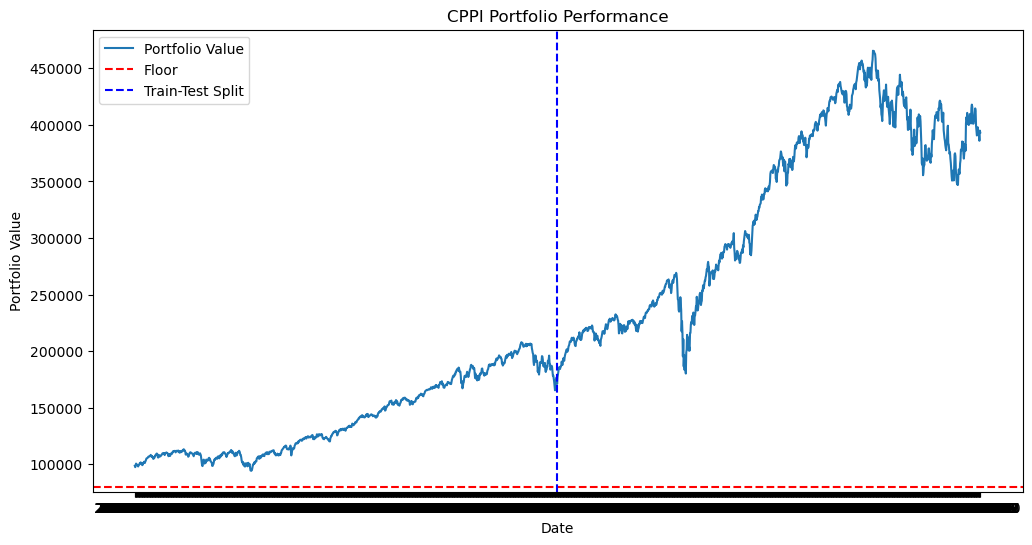

Training Final Portfolio Value: 177023.23863488558
Testing Final Portfolio Value: 393258.3388638171


In [6]:
# Split stock and bond data
train_stock = data_stock.loc[train_start:train_end]
test_stock = data_stock.loc[test_start:test_end]

train_bond = data_bond.loc[train_start:train_end]
test_bond = data_bond.loc[test_start:test_end]

# Calculate risk-free rates
risk_free_rate_train = train_bond.pct_change().mean().mean()  # Mean of all bonds in training
risk_free_rate_test = test_bond.pct_change().mean().mean()    # Mean of all bonds in testing

# Apply CPPI on training and testing data
train_stock_returns = train_stock.pct_change().dropna()
portfolio_values_train = apply_cppi(
    stock_returns=train_stock_returns,
    risk_free_rate=risk_free_rate_train,
    floor=floor_value,
    initial_value=initial_portfolio_value,
    multiplier=multiplier
)

test_stock_returns = test_stock.pct_change().dropna()
portfolio_values_test = apply_cppi(
    stock_returns=test_stock_returns,
    risk_free_rate=risk_free_rate_test,
    floor=floor_value,
    initial_value=portfolio_values_train[-1],  # Start from the last training value
    multiplier=multiplier
)

# Adjust indices for training and testing results
train_index = train_stock.index[1:len(portfolio_values_train)+1]
portfolio_values_train = portfolio_values_train[:len(train_index)]

test_index = test_stock.index[1:len(portfolio_values_test)+1]
portfolio_values_test = portfolio_values_test[:len(test_index)]

# Create DataFrames for training and testing
train_results = pd.DataFrame({"Portfolio Value": portfolio_values_train}, index=train_index)
test_results = pd.DataFrame({"Portfolio Value": portfolio_values_test}, index=test_index)

# Combine results
combined_results = pd.concat([train_results, test_results], axis=0)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(combined_results, label="Portfolio Value")
plt.axhline(y=floor_value, color="red", linestyle="--", label="Floor")
plt.axvline(x=train_index[-1], color="blue", linestyle="--", label="Train-Test Split")
plt.title("CPPI Portfolio Performance")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

# Print final results
print("Training Final Portfolio Value:", portfolio_values_train[-1])
print("Testing Final Portfolio Value:", portfolio_values_test[-1])


## Rolling floor

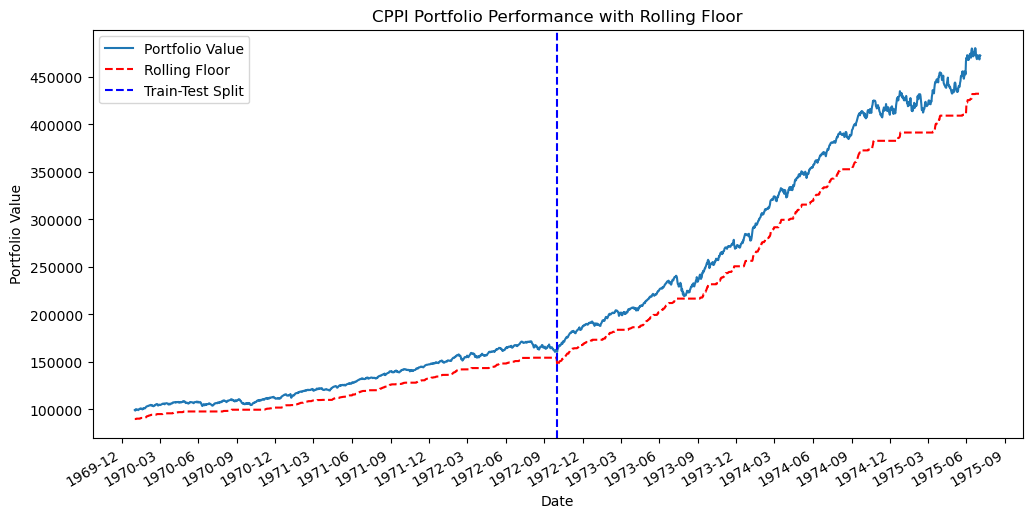

In [9]:
def apply_cppi_with_rolling_floor(stock_returns, risk_free_rate, floor_percentage, initial_value, multiplier):
    portfolio_value = initial_value
    portfolio_values = []
    floor_values = []
    max_portfolio_value = initial_value

    for daily_return in stock_returns.mean(axis=1):  # Equal-weighted stock returns
        # Update the rolling floor
        floor = floor_percentage * max_portfolio_value

        # Calculate cushion
        cushion = max(portfolio_value - floor, 0)

        # Allocate to risky and risk-free assets
        risky_allocation = min(multiplier * cushion, portfolio_value)
        risk_free_allocation = portfolio_value - risky_allocation

        # Compute portfolio return
        risky_return = risky_allocation * daily_return
        risk_free_return = risk_free_allocation * risk_free_rate
        portfolio_return = risky_return + risk_free_return

        # Update portfolio value and track the maximum value
        portfolio_value += portfolio_return
        max_portfolio_value = max(max_portfolio_value, portfolio_value)

        # Record values
        portfolio_values.append(portfolio_value)
        floor_values.append(floor)
    
    return portfolio_values, floor_values

# Apply CPPI with rolling floor on training data
portfolio_values_train, floor_values_train = apply_cppi_with_rolling_floor(
    stock_returns=train_stock_returns,
    risk_free_rate=risk_free_rate_train,
    floor_percentage=0.90,
    initial_value=initial_portfolio_value,
    multiplier=multiplier
)

# Apply CPPI with rolling floor on testing data
portfolio_values_test, floor_values_test = apply_cppi_with_rolling_floor(
    stock_returns=test_stock_returns,
    risk_free_rate=risk_free_rate_test,
    floor_percentage=0.90,
    initial_value=portfolio_values_train[-1],
    multiplier=multiplier
)

# Adjust indices for plotting
train_index = train_stock.index[1:len(portfolio_values_train)+1]
test_index = test_stock.index[1:len(portfolio_values_test)+1]

# Create DataFrames for portfolio and floor values
train_results = pd.DataFrame({
    "Portfolio Value": portfolio_values_train,
    "Rolling Floor": floor_values_train
}, index=train_index)

test_results = pd.DataFrame({
    "Portfolio Value": portfolio_values_test,
    "Rolling Floor": floor_values_test
}, index=test_index)

# Combine results
combined_results = pd.concat([train_results, test_results], axis=0)



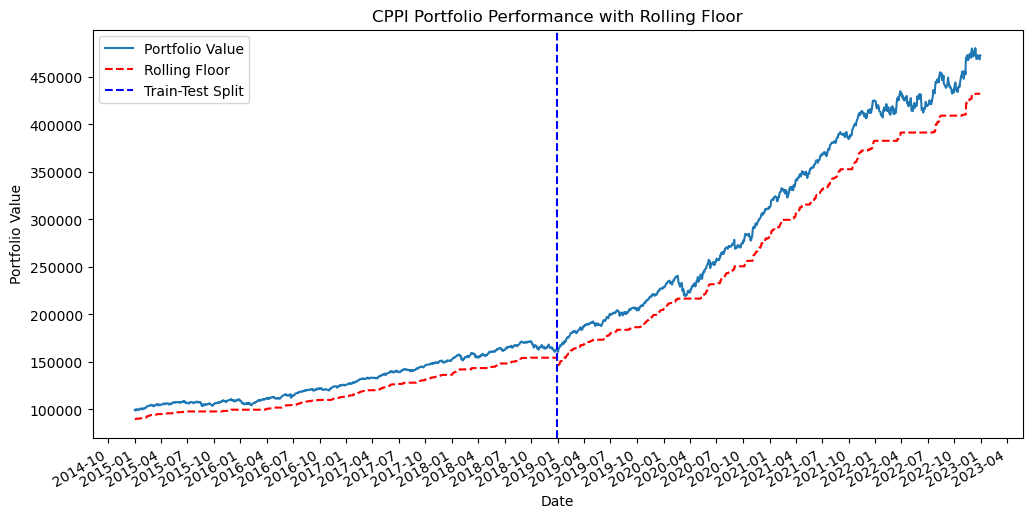

In [13]:
# Ensure train_index and test_index are datetime objects
train_index = pd.to_datetime(train_index)
test_index = pd.to_datetime(test_index)

# Combine results
combined_results.index = pd.to_datetime(combined_results.index)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(combined_results["Portfolio Value"], label="Portfolio Value")
plt.plot(combined_results["Rolling Floor"], label="Rolling Floor", linestyle="--", color="red")

# Add train-test split line
plt.axvline(x=train_index[-1], color="blue", linestyle="--", label="Train-Test Split")

# Add title and labels
plt.title("CPPI Portfolio Performance with Rolling Floor")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format x-axis for better readability
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'
plt.gcf().autofmt_xdate()

# Show plot
plt.show()


In [38]:
import pandas as pd
import numpy as np

# Function to calculate portfolio performance metrics
def calculate_metrics(returns, risk_free_rate):
    # Sharpe Ratio
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(returns)

    # Volatility (annualized)
    volatility = np.std(returns) * np.sqrt(252)

    # CAR (Cumulative Annualized Return)
    car = np.cumprod(1 + returns)[-1] ** (252 / len(returns)) - 1

    # Max Drawdown
    cumulative = np.cumprod(1 + returns)
    drawdown = cumulative / np.maximum.accumulate(cumulative) - 1
    max_drawdown = drawdown.min()

    return sharpe_ratio, volatility, car, max_drawdown

# Simulate multiple trials for percentiles
simulations = 1000
sharpe_ratios = []
volatilities = []
cumulative_returns = []
max_drawdowns = []
dd_95_percentiles = []

for _ in range(simulations):
    # Bootstrap portfolio returns for simulation
    simulated_returns = np.random.choice(test_stock_returns.mean(axis=1), size=len(test_stock_returns), replace=True)
    
    # Calculate CPPI portfolio values and returns using rolling floor
    simulated_values, _ = apply_cppi_with_rolling_floor(
        stock_returns=pd.DataFrame(simulated_returns),
        risk_free_rate=risk_free_rate_test,
        floor_percentage=0.90,
        initial_value=initial_portfolio_value,
        multiplier=multiplier
    )
    
    # Calculate returns from portfolio values
    simulated_returns = np.diff(simulated_values) / simulated_values[:-1]
    
    # Calculate metrics
    sharpe, vol, car, max_dd = calculate_metrics(simulated_returns, risk_free_rate_test)
    sharpe_ratios.append(sharpe)
    volatilities.append(vol)
    cumulative_returns.append(car)
    max_drawdowns.append(max_dd)
    
    # 95% Drawdown
    cumulative = np.cumprod(1 + simulated_returns)
    drawdown = cumulative / np.maximum.accumulate(cumulative) - 1
    dd_95_percentiles.append(np.percentile(drawdown, 5))  # 95% DD

# Create a DataFrame for the simulation results
simulation_results = pd.DataFrame({
    "Sharpe Ratio": sharpe_ratios,
    "Volatility p.a.": volatilities,
    "CAR p.a.": cumulative_returns,
    "Max Drawdown": max_drawdowns,
    "95% DD": dd_95_percentiles
})

# Calculate desired percentiles
summary_table = pd.DataFrame({
    "Metric": ["Sharpe Ratio", "Volatility p.a.", "CAR p.a.", "Max Drawdown", "95% DD"],
    "5th Percentile": simulation_results.quantile(0.05),
    "Median": simulation_results.median(),
    "95th Percentile": simulation_results.quantile(0.95)
}).set_index("Metric")

# Add CAR / Max DD and CAR / 95% DD ratios
summary_table.loc["CAR / Max DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["Max Drawdown"])
summary_table.loc["CAR / 95% DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["95% DD"])

# Display the table
print(summary_table)

# Optional: Export to CSV or Excel
#summary_table.to_csv("simulation_table_cppi_rolling_floor.csv")


                 5th Percentile    Median  95th Percentile
Metric                                                    
Sharpe Ratio          -0.074642 -0.026482         0.026951
Volatility p.a.        0.099213  0.106964         0.115849
CAR p.a.               0.224606  0.319001         0.447211
Max Drawdown          -0.078159 -0.065729        -0.052326
95% DD                -0.057914 -0.045963        -0.034128
CAR / Max DD           2.873685  4.853282         8.546564
CAR / 95% DD           3.878288  6.940393        13.103786


In [ ]:
# Ensure train_index and test_index are datetime objects
train_index = pd.to_datetime(train_index)
test_index = pd.to_datetime(test_index)

# Combine results
combined_results.index = pd.to_datetime(combined_results.index)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(combined_results["Portfolio Value"], label="Portfolio Value")
plt.plot(combined_results["Rolling Floor"], label="Rolling Floor", linestyle="--", color="red")

# Add train-test split line
plt.axvline(x=train_index[-1], color="blue", linestyle="--", label="Train-Test Split")

# Add title and labels
plt.title("CPPI Portfolio Performance with Rolling Floor")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format x-axis for better readability
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'
plt.gcf().autofmt_xdate()

# Show plot
plt.show()


# Markowitz + CPPI

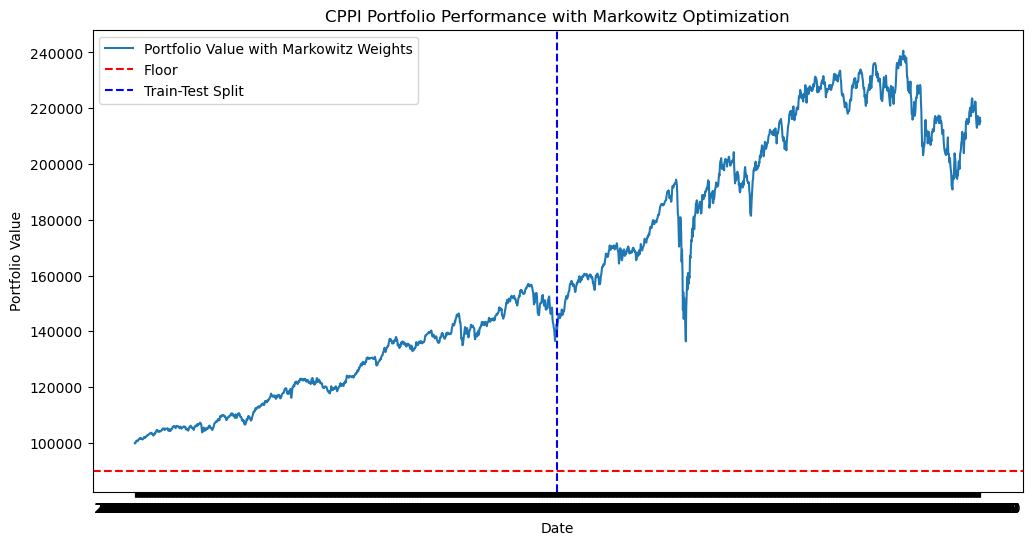

Training Final Portfolio Value: 142516.4788881637
Testing Final Portfolio Value: 215304.97358633226


In [23]:
# Function to calculate Markowitz optimal weights (from your file)
def calculate_optimal_weights(returns, risk_free_rate, target="min_vol"):
    """
    Calculate Markowitz optimal portfolio weights based on the target:
    - target = "min_vol" for minimum variance portfolio
    - target = "max_ret" for maximum return portfolio
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    
    # Helper functions
    def portfolio_performance(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_return, portfolio_volatility
    
    def objective_min_volatility(weights):
        return portfolio_performance(weights)[1]  # Minimize volatility
    
    def objective_max_return(weights):
        return -np.dot(weights, mean_returns)  # Maximize returns (negative for minimization)
    
    # Constraints and bounds
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Weights sum to 1
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling
    
    # Optimization
    if target == "min_vol":
        result = minimize(objective_min_volatility, num_assets * [1. / num_assets], 
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif target == "max_ret":
        result = minimize(objective_max_return, num_assets * [1. / num_assets], 
                          method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        raise ValueError("Unknown target. Choose 'min_vol' or 'max_ret'.")
    
    return result.x  # Optimal weights

# Updated CPPI function
def apply_cppi(stock_returns, risk_free_rate, floor, initial_value, multiplier, weights):
    portfolio_value = initial_value
    portfolio_values = []
    
    for daily_returns in stock_returns.values:
        risky_return = np.dot(weights, daily_returns)  # Weighted returns
        cushion = max(portfolio_value - floor, 0)
        risky_allocation = min(multiplier * cushion, portfolio_value)
        risk_free_allocation = portfolio_value - risky_allocation
        portfolio_return = risky_allocation * risky_return + risk_free_allocation * risk_free_rate
        
        # Update portfolio value
        portfolio_value += portfolio_return
        portfolio_values.append(portfolio_value)
    
    return portfolio_values

# Training data
train_stock_returns = train_stock.pct_change().dropna()

# Use the Markowitz function from your file to calculate weights
optimal_weights = calculate_optimal_weights(train_stock_returns, risk_free_rate_train, target="min_vol")

# Apply CPPI with calculated Markowitz weights
portfolio_values_train = apply_cppi(
    stock_returns=train_stock_returns,
    risk_free_rate=risk_free_rate_train,
    floor=floor_value,
    initial_value=initial_portfolio_value,
    multiplier=multiplier,
    weights=optimal_weights
)

# Testing data
test_stock_returns = test_stock.pct_change().dropna()

portfolio_values_test = apply_cppi(
    stock_returns=test_stock_returns,
    risk_free_rate=risk_free_rate_test,
    floor=floor_value,
    initial_value=portfolio_values_train[-1],  # Start from last training value
    multiplier=multiplier,
    weights=optimal_weights
)

# Combine and visualize results
train_index = train_stock.index[1:len(portfolio_values_train)+1]
test_index = test_stock.index[1:len(portfolio_values_test)+1]

train_results = pd.DataFrame({"Portfolio Value": portfolio_values_train}, index=train_index)
test_results = pd.DataFrame({"Portfolio Value": portfolio_values_test}, index=test_index)

combined_results = pd.concat([train_results, test_results])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined_results, label="Portfolio Value with Markowitz Weights")
plt.axhline(y=floor_value, color="red", linestyle="--", label="Floor")
plt.axvline(x=train_index[-1], color="blue", linestyle="--", label="Train-Test Split")
plt.title("CPPI Portfolio Performance with Markowitz Optimization")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

# Print final results
print("Training Final Portfolio Value:", portfolio_values_train[-1])
print("Testing Final Portfolio Value:", portfolio_values_test[-1])


In [24]:
# CPPI function to calculate portfolio returns
def calculate_cppi_portfolio_returns(stock_returns, risk_free_rate, floor, initial_value, multiplier):
    portfolio_value = initial_value
    portfolio_values = []
    portfolio_returns = []  # Store portfolio returns at each step

    for i in range(len(stock_returns)):
        risky_return = stock_returns[i]  # Risky asset return at time t
        
        # Calculate cushion and allocations
        cushion = max(portfolio_value - floor, 0)
        risky_allocation = min(multiplier * cushion, portfolio_value)
        risk_free_allocation = portfolio_value - risky_allocation
        
        # Portfolio return
        portfolio_return = (
            (risky_allocation / portfolio_value) * risky_return + 
            (risk_free_allocation / portfolio_value) * risk_free_rate
        )
        
        # Update portfolio value
        portfolio_value *= (1 + portfolio_return)
        
        # Store results
        portfolio_values.append(portfolio_value)
        portfolio_returns.append(portfolio_return)
    
    return portfolio_values, portfolio_returns

# Example usage
initial_portfolio_value = 100000
floor_percentage = 0.90
multiplier = 3
floor_value = floor_percentage * initial_portfolio_value

# Stock returns and risk-free rate (replace with actual data)
stock_returns = test_stock_returns.mean(axis=1).values  # Risky asset daily returns
risk_free_rate = risk_free_rate_test  # Replace with the actual daily risk-free rate


# Calculate portfolio values and returns
portfolio_values, portfolio_returns = calculate_cppi_portfolio_returns(
    stock_returns=stock_returns,
    risk_free_rate=risk_free_rate,
    floor=floor_value,
    initial_value=initial_portfolio_value,
    multiplier=multiplier
)

# Ensure the portfolio_returns align with the index of test_stock_returns
# Drop the first date in the index to match the returns length
portfolio_returns = pd.Series(portfolio_returns, index=test_stock_returns.index[:len(portfolio_returns)])



In [25]:
import pandas as pd
import numpy as np

# Assuming you have the following:
# portfolio_returns: A pandas Series of daily returns for the portfolio (from Markowitz + CPPI)
# risk_free_rate: Daily risk-free rate used in the portfolio

# Placeholder for your portfolio returns and risk-free rate
# Replace this with your actual data
 # Replace with actual portfolio daily returns
risk_free_rate = risk_free_rate_test  # Replace with the actual daily risk-free rate

# Function to calculate portfolio performance metrics
def calculate_metrics(returns, risk_free_rate):
    # Sharpe Ratio
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(returns)

    # Volatility (annualized)
    volatility = np.std(returns) * np.sqrt(252)

    # CAR (Cumulative Annualized Return)
    car = np.cumprod(1 + returns)[-1] ** (252 / len(returns)) - 1

    # Max Drawdown
    cumulative = np.cumprod(1 + returns)
    drawdown = cumulative / np.maximum.accumulate(cumulative) - 1
    max_drawdown = drawdown.min()

    return sharpe_ratio, volatility, car, max_drawdown

# Simulate multiple trials for percentiles
simulations = 1000
sharpe_ratios = []
volatilities = []
cumulative_returns = []
max_drawdowns = []
dd_95_percentiles = []

for _ in range(simulations):
    # Bootstrap simulated returns
    simulated_returns = np.random.choice(portfolio_returns, size=len(portfolio_returns), replace=True)
    
    # Calculate metrics
    sharpe, vol, car, max_dd = calculate_metrics(simulated_returns, risk_free_rate)
    sharpe_ratios.append(sharpe)
    volatilities.append(vol)
    cumulative_returns.append(car)
    max_drawdowns.append(max_dd)
    
    # Calculate 95% drawdown for each trial
    cumulative = np.cumprod(1 + simulated_returns)
    drawdown = cumulative / np.maximum.accumulate(cumulative) - 1
    dd_95_percentiles.append(np.percentile(drawdown, 5))  # 95% DD

# Create a DataFrame for the simulation results
simulation_results = pd.DataFrame({
    "Sharpe Ratio": sharpe_ratios,
    "Volatility p.a.": volatilities,
    "CAR p.a.": cumulative_returns,
    "Max Drawdown": max_drawdowns,
    "95% DD": dd_95_percentiles
})

# Calculate desired percentiles
summary_table = pd.DataFrame({
    "Metric": ["Sharpe Ratio", "Volatility p.a.", "CAR p.a.", "Max Drawdown", "95% DD"],
    "5th Percentile": simulation_results.quantile(0.05),
    "Median": simulation_results.median(),
    "95th Percentile": simulation_results.quantile(0.95)
}).set_index("Metric")

# Add CAR / Max DD and CAR / 95% DD ratios
summary_table.loc["CAR / Max DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["Max Drawdown"])
summary_table.loc["CAR / 95% DD"] = summary_table.loc["CAR p.a."] / abs(summary_table.loc["95% DD"])

# Display the table
print(summary_table)

# Optional: Export to CSV or Excel for easier visualization
#summary_table.to_csv("simulation_table_cppi_markowitz.csv")


                 5th Percentile    Median  95th Percentile
Metric                                                    
Sharpe Ratio          -0.094762 -0.041128         0.009172
Volatility p.a.        0.196064  0.208412         0.221751
CAR p.a.              -0.007356  0.186351         0.401874
Max Drawdown          -0.419044 -0.259014        -0.159240
95% DD                -0.375952 -0.205373        -0.116762
CAR / Max DD          -0.017554  0.719463         2.523707
CAR / 95% DD          -0.019566  0.907376         3.441835
